<a href="https://colab.research.google.com/github/gmonday116/PIC16AFinal/blob/main/Pic_16A_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Group Contributions Statement


Both of us contributed to the model complexity selection pipeline, plotting confusion matrices, and the discussions of the performance for each optimized model. George led visualization of qualitative data in the exploratory analysis, the creation of the correlation coefficient heat map in feature selection, plotting decision regions, and writing functions to assess the accuracy of each model. Daniel led preparation of the data, visualization of quantitative data, and cross-validation analysis to select the best combination of qualitative and quantitative features. We all edited each other's code to improve more concision and efficiency. 


## 2.A. Importing the Data and Relevant Modules/Functions

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, ssl

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import ShuffleSplit



In [ ]:
url = "https://philchodrow.github.io/PIC16A/datasets/palmer_penguins.csv"
penguins = pd.read_csv(url)
penguins



,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,PAL0910,120,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A2,No,12/1/09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
340,PAL0910,121,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N39A1,Yes,11/22/09,46.8,14.3,215.0,4850.0,FEMALE,8.41151,-26.13832,NaN
341,PAL0910,122,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N39A2,Yes,11/22/09,50.4,15.7,222.0,5750.0,MALE,8.30166,-26.04117,NaN
342,PAL0910,123,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N43A1,Yes,11/22/09,45.2,14.8,212.0,5200.0,FEMALE,8.24246,-26.11969,NaN


## 2.B. Splitting and Cleaning up the Data

In [ ]:
# splitting up the data into training and test
train, test = train_test_split(penguins, test_size = 0.3)

In [ ]:
# seeing if the region variable is the same across all rows
any(penguins['Region'] !=  'Anvers')

False

In [ ]:
# function to prepare the data
def prep_peng_data(data_df, categ_cols = []):

    '''
    Function that prepares the penguins data frame by dropping unnecessary columns and label encoding categorical columns. 
    Takes the penguins data frame as an argument and a list of categorical columns to be label encoded. 
    By default, the function will not label encode any columns. 

    Parameters:
    -----------
    data_df: expects the penguins data frame

    categ_cols: default value is an empty list. Takes a list of categorical column names to be label encoded

    Return values:
    --------------
    df: the modified data frame

    '''

    df = data_df.copy()
    
    # dropping unnecessary columns
    df = df.drop(['studyName', 'Sample Number', 'Region', 'Stage', 'Date Egg', 'Individual ID', 'Comments'], axis = 1)
    
    # drop the penguins that have na values in any column
    df = df.dropna()
    
    # drop that one penguin that has a "." as the sex
    df = df.drop(df.loc[df['Sex'] == '.'].index)
    
    # label encoder for application to columns with categorical data
    le = preprocessing.LabelEncoder()
    
    if len(categ_cols) != 0:
      for col in categ_cols:
          df[col] = le.fit_transform(df[col])
    
    return df
    

In [ ]:
train_prep = prep_peng_data(train, categ_cols = ['Species', 'Island', 'Clutch Completion', 'Sex'])
train_prep.head()

,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
203,1,1,1,51.4,19.0,201.0,3950.0,1,9.43782,-24.36202
98,0,1,1,33.1,16.1,178.0,2900.0,0,9.04218,-26.15775
118,0,2,1,35.7,17.0,189.0,3350.0,0,8.96436,-23.90309
188,1,1,1,47.6,18.3,195.0,3850.0,0,8.83502,-24.65859
80,0,2,1,34.6,17.2,189.0,3200.0,0,7.69778,-26.53870


## 3. Exploratory Analysis

### Quantitative Data Summary Table

In [ ]:
quan_dat = penguins.groupby(['Species', 'Island'])[['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)']].mean()

quan_dat.style.set_caption('Table 1: Summary of Quantative Data by Species and Island')

*Discussion*
* On average, it seems that:
1. Gentoos have the highest flipper length and body mass, but the lowest culmen depth
2. Gentoos have a similar culmen length to Chinstraps
3. Chinstraps have the highest culmen length and similar culmen depth to Adelies
4. Chinstraps and Adelies have similar body mass, culmen depth, and flipper length

* Because Chinstraps and Adelies are similar in body mass, culmen depth, and flipper length, our model will only select one feature from this set of similar attributes. 
* Hence, our model will use a quantitative feature, possibly **body mass, culmen depth, or flipper length**, from the aforementioned list to distinguish Biscoe penguins and Adelies/Chinstraps 

* To help distinguish between Adelies and Chinstraps, we will use **culmen length** and **island inhabitance**, since the two species significantly differ in culmen length, and only Adelies inhabit the Torgeson island

### Qualitative Data Summary Table

In [ ]:
peng_c1 = prep_peng_data(penguins)

# counting members of each sex per species
res = peng_c1.pivot_table(index=['Species'], columns=['Sex'], aggfunc='size', fill_value=0)

# generating a sex ratio
res['Sex Ratio (Female:Male)'] = res['FEMALE'] / res['MALE']

# counting the penguins that achieved clutch completion per species
res1 = peng_c1.pivot_table(index=['Species'], columns='Clutch Completion', aggfunc='size', fill_value=0)

# generating a clutch completion ratio
res['Clutch Completion Ratio (Yes:total)'] = res1['Yes'].values / (res1['Yes'].values + res1['No'].values)

# formatting the table
res.columns.name = None
res = res.drop(['FEMALE', 'MALE'], axis = 1)
res.style.set_caption('Table 2: Ratios of Qualitative Data by Species')

,Sex Ratio (Female:Male),Clutch Completion Ratio (Yes:total)
Species,,
Adelie Penguin (Pygoscelis adeliae),1.044118,0.906475
Chinstrap penguin (Pygoscelis antarctica),1.030303,0.791045
Gentoo penguin (Pygoscelis papua),0.966667,0.940678


*Discussion*

* Overall, it seems that all three species differ in sex ratio and clutch completion ratio
* Adelie and Chinstrap penguins have similar sex ratios
* Differences across species are more pronounced in clutch completion ratio 

In [ ]:
# see above for new implementation of qualitative data table

peng_c1 = prep_peng_data(penguins)
x = peng_c1.sort_values(['Species'])
res = x.pivot_table(index=['Species'], columns='Sex', aggfunc='size', fill_value=0)

res['cumulative_Female']=res.groupby(['Species'])['FEMALE'].cumsum()
res['cumulative_Male']=res.groupby(['Species'])['MALE'].cumsum()
res["Sex Ratio (Female:Male)"] = res['cumulative_Female']/ (res['cumulative_Female']+res['cumulative_Male'])

res1 = x.pivot_table(index=['Species'], columns='Clutch Completion', aggfunc='size', fill_value=0)
res1['cumulative_No']=res1.groupby(['Species'])['No'].cumsum()
res1['cumulative_Yes']=res1.groupby(['Species'])['Yes'].cumsum()

res["Clutch Completion Ratio (Yes:No)"] = res1['cumulative_Yes']/ (res1['cumulative_Yes']+res1['cumulative_No'])
res = res.drop(["FEMALE", "MALE", "cumulative_Female", "cumulative_Male"], axis =1)

res.style.set_caption('Table 2: Ratios of Qualitative Data by Species')

Sex,Sex Ratio (Female:Male),Clutch Completion Ratio (Yes:No)
Species,,
Adelie Penguin (Pygoscelis adeliae),0.510791,0.906475
Chinstrap penguin (Pygoscelis antarctica),0.507463,0.791045
Gentoo penguin (Pygoscelis papua),0.491525,0.940678


### Finding features that give the best clustering

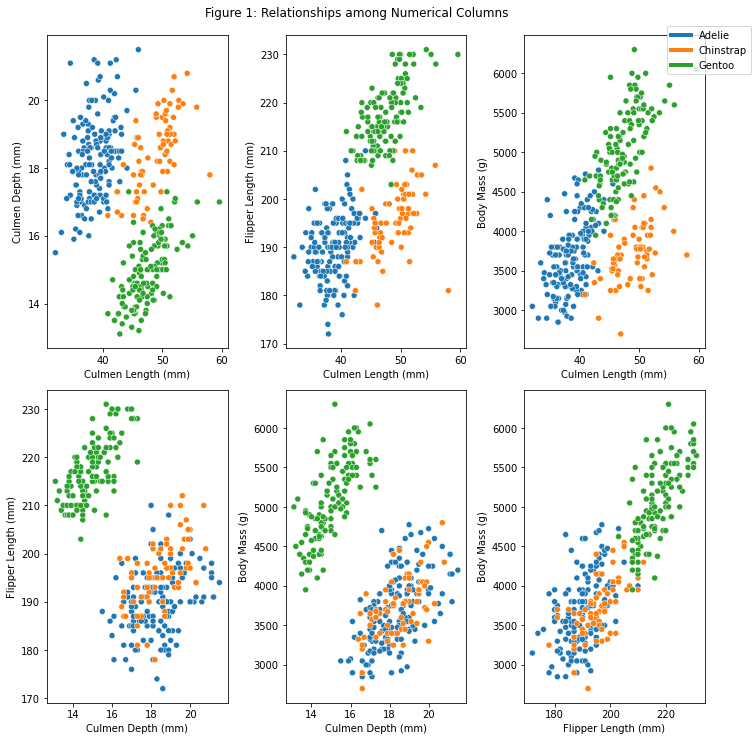

In [ ]:
from matplotlib.lines import Line2D

# information for the custom figure legend
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
cont_clrs = cycle[:3]
specs_abrev = [spec.split()[0] for spec in penguins['Species'].unique()]
custom_lines = [Line2D([0], [0], color = cont_clr, lw = 4) for cont_clr in cont_clrs]

fig1, ax = plt.subplots(2, 3, figsize = (10, 10))

# generating all pairs of numeric columns
num_cols = penguins.columns[9:13]
num_col_pairs = [[num_cols[i], num_cols[j]] for i in range(len(num_cols) - 1) for j in range(i + 1, len(num_cols))]
        
# dictionary matching a 2D index to each of the numeric column pairs
ind_dict = dict(zip(range(6), [tuple([i, j]) for i in range(2) for j in range(3)]))

# creating the scatterplots using sns.scatter
for i in range(len(num_col_pairs)):
    sns.scatterplot(data = penguins, 
                        x = num_col_pairs[i][0], 
                        y = num_col_pairs[i][1], 
                        hue = 'Species', 
                        ax = ax[ind_dict[i]],
                        legend = False)

# adding the figure title and legend
fig1.suptitle('Figure 1: Relationships among Numerical Columns', x = 0.5, y = 1.025)
fig1.legend(custom_lines, specs_abrev, bbox_to_anchor=(1.05, 1))

plt.tight_layout()

*Discussion*
* From these scatterplots, it seems that any quantitative column pairing that includes culmen length provides good clustering of the data
* These pairings produce distinct clusters of points that correspond to a certain penguin species
* Culmen length seems like a good way of distinguishing between Adelies and Chinstraps, given the two species' similarities in flipper length, body mass, and culmen depth
* Quantatitive features other than culmen length need to be examined more closely to determine their informativeness in distinguishing species

### Visualizing culmen depth, flipper length, and body mass more closely

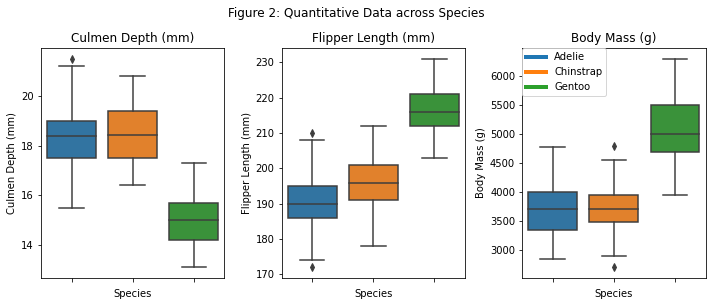

In [ ]:
# box plots for flipper length and body mass across species
fig2, ax = plt.subplots(1,3, figsize = (10, 4))
quan_cols = ['Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)']

for i in range(len(quan_cols)):

  sns.boxplot(data = penguins, 
                    x = 'Species',
                    y = quan_cols[i],
                    hue = 'Species',
                    dodge = False, 
                    ax = ax[i])

  # getting rid of axis labels
  ax[i].set_xticklabels([])

  # adding a title
  ax[i].set(title = quan_cols[i])

  # removing legend from all plots
  if i == 2:
    ax[2].legend(custom_lines, 
                 penguins['Species'].str.split().str.get(0).unique(),
                 loc = 'upper left',
                 borderaxespad=0)
  else:
    ax[i].legend([],[], frameon = False)
  
# adding figure title
fig2.suptitle('Figure 2: Quantitative Data across Species', x = 0.5, y  = 1.05)
plt.tight_layout()

### Using histograms to examine overlaps in boxplot whiskers for flipper length and body mass

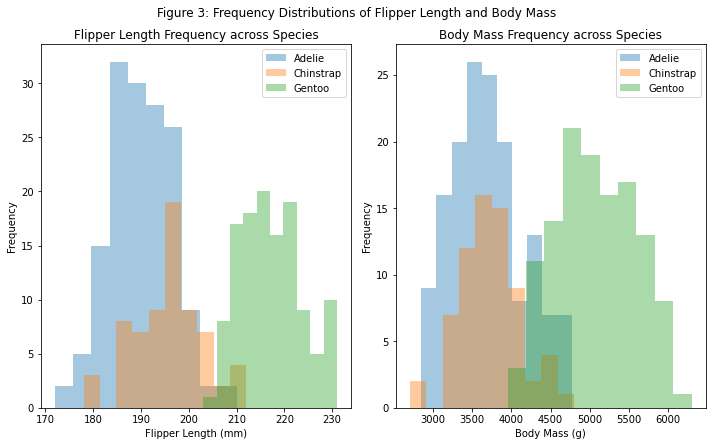

In [ ]:
fig3, ax = plt.subplots(1, 2, figsize = (10, 6))
spec_list = penguins['Species'].unique()

for spec in spec_list:
    ax[0].hist(penguins['Flipper Length (mm)'][penguins['Species'] == spec], 
            alpha = 0.4, 
            label = spec.split()[0])
    ax[1].hist(penguins['Body Mass (g)'][penguins['Species'] == spec], 
            alpha = 0.4, 
            label = spec.split()[0])

ax[0].set(xlabel = 'Flipper Length (mm)', 
       ylabel = 'Frequency', 
       title =  'Flipper Length Frequency across Species')
ax[0].legend()

ax[1].set(xlabel = 'Body Mass (g)', 
       ylabel = 'Frequency', 
       title =  'Body Mass Frequency across Species')
ax[1].legend()

fig3.suptitle('Figure 3: Frequency Distributions of Flipper Length and Body Mass', x = 0.5, y = 1.025)
plt.tight_layout()

## 4.  Feature Selection

### Correlation coefficients among columns to check for possible multicollinearity issues among quantitative column pairs

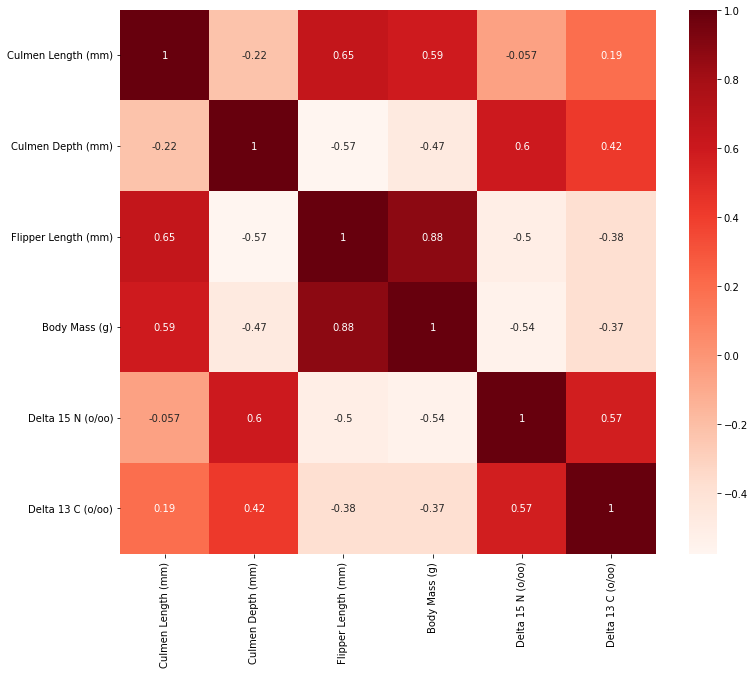

In [ ]:
plt.figure(figsize=(12,10))

peng_c2 = prep_peng_data(penguins)
cor = peng_c2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### Cross-Validation Evaluations

#### i) Parameters Set Candidates and Helper Functions

In [ ]:
# creating parameter set candidates
inf_ncp = [['Culmen Length (mm)', 'Culmen Depth (mm)'],
           ['Culmen Length (mm)', 'Flipper Length (mm)'],
           ['Culmen Length (mm)', 'Body Mass (g)']]

inf_ctg = ['Island', 'Sex', 'Clutch Completion']

param_cands = [ncp + [ctg] for ctg in inf_ctg for ncp in inf_ncp]

In [ ]:
# function to find cv scores
def find_cv_score(model, params, hold_out = 10):
  '''
  Function that finds the average cross-validation score of a machine learning model trained on the penguins data set using a
  specified set of features from the original penguins data frame. Default hold-out value is 10% of the training data.

  Parameters:
  -----------
  model: a machine learning model object

  params: a set of features on which to train the model

  hold_out: the percent of the training data to hold out during cross validation. default value is 10. 

  Return values:
  --------------
  params: the feature set used to train the model

  cross_val_score.mean(): the average cross validation score of the model 

  '''

  # subset the training data
  X_train = train_prep[params]
  y_train = train_prep['Species']

  # if the model is logistic regression, then normalize the values by max and min
  if type(model) == type(LogisticRegression()):
    X_train =(X_train - X_train.min()) / (X_train.max() - X_train.min())
  return (params, cross_val_score(model, X_train, y_train, cv = hold_out).mean())


In [ ]:
# function to find the cv best score
def find_best_score(model):

  '''
  Function that finds and returns the best cross-validation score for
  a user-specified model and the feature set that produced the best
  cross-validation score.

  Parameters:
  -----------
  model: a machine learning model input

  Return values:
  --------------
  best_prms: a list of the feature list that produced the best cross-validation score

  best_cv: the best cross-validation score achieved by the model

  '''

  # empty lists to hold cv scores and feature sets
  cvs = []
  prms = []

  # finding the cv score for each of the feature set candidates
  for i in range(len(param_cands)):
    res = find_cv_score(model, param_cands[i])
    prms.append(res[0])
    cvs.append(res[1])
    print(res)
  
  # storing the best cv score and corresponding feature set
  best_cv = max(cvs)
  best_prms = prms[cvs.index(best_cv)]

  print('\n')
  print('Best parameter set and cv:')

  return best_prms, best_cv



#### ii.a) Cross-Validating Multinomial Logistic Regression

In [ ]:
MLR = LogisticRegression(multi_class='multinomial', solver = 'lbfgs')
find_best_score(MLR)

(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island'], 0.9468379446640316)
(['Culmen Length (mm)', 'Flipper Length (mm)', 'Island'], 0.9466403162055336)
(['Culmen Length (mm)', 'Body Mass (g)', 'Island'], 0.9335968379446641)
(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex'], 0.9733201581027668)
(['Culmen Length (mm)', 'Flipper Length (mm)', 'Sex'], 0.9729249011857709)
(['Culmen Length (mm)', 'Body Mass (g)', 'Sex'], 0.9687747035573123)
(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Clutch Completion'], 0.9335968379446641)
(['Culmen Length (mm)', 'Flipper Length (mm)', 'Clutch Completion'], 0.9332015810276679)
(['Culmen Length (mm)', 'Body Mass (g)', 'Clutch Completion'], 0.8893280632411067)


Best parameter set and cv:


(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex'], 0.9733201581027668)

#### ii.b) Cross-Validating Random Forest Classification

In [ ]:
RFC = RandomForestClassifier()
find_best_score(RFC)

(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island'], 0.9867588932806324)
(['Culmen Length (mm)', 'Flipper Length (mm)', 'Island'], 0.9867588932806324)
(['Culmen Length (mm)', 'Body Mass (g)', 'Island'], 0.9559288537549409)
(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex'], 0.9824110671936758)
(['Culmen Length (mm)', 'Flipper Length (mm)', 'Sex'], 0.9776679841897234)
(['Culmen Length (mm)', 'Body Mass (g)', 'Sex'], 0.9820158102766798)
(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Clutch Completion'], 0.9515810276679841)
(['Culmen Length (mm)', 'Flipper Length (mm)', 'Clutch Completion'], 0.9600790513833992)
(['Culmen Length (mm)', 'Body Mass (g)', 'Clutch Completion'], 0.9205533596837945)


Best parameter set and cv:


(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island'], 0.9867588932806324)

#### ii.c) Cross-Validating Support Vector Classification

In [ ]:
SVM = svm.SVC()
find_best_score(SVM)

(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island'], 0.8804347826086956)
(['Culmen Length (mm)', 'Flipper Length (mm)', 'Island'], 0.7786561264822134)
(['Culmen Length (mm)', 'Body Mass (g)', 'Island'], 0.699604743083004)
(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex'], 0.8541501976284585)
(['Culmen Length (mm)', 'Flipper Length (mm)', 'Sex'], 0.7786561264822134)
(['Culmen Length (mm)', 'Body Mass (g)', 'Sex'], 0.699604743083004)
(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Clutch Completion'], 0.8584980237154151)
(['Culmen Length (mm)', 'Flipper Length (mm)', 'Clutch Completion'], 0.7786561264822134)
(['Culmen Length (mm)', 'Body Mass (g)', 'Clutch Completion'], 0.699604743083004)


Best parameter set and cv:


(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island'], 0.8804347826086956)

#### ii.d) Cross-Validating Nearest Neighbor Classification

In [ ]:
KNN = KNeighborsClassifier()
find_best_score(KNN)

(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island'], 0.9776679841897234)
(['Culmen Length (mm)', 'Flipper Length (mm)', 'Island'], 0.9640316205533598)
(['Culmen Length (mm)', 'Body Mass (g)', 'Island'], 0.7120553359683794)
(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex'], 0.9820158102766798)
(['Culmen Length (mm)', 'Flipper Length (mm)', 'Sex'], 0.9640316205533598)
(['Culmen Length (mm)', 'Body Mass (g)', 'Sex'], 0.7120553359683794)
(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Clutch Completion'], 0.9598814229249012)
(['Culmen Length (mm)', 'Flipper Length (mm)', 'Clutch Completion'], 0.9640316205533598)
(['Culmen Length (mm)', 'Body Mass (g)', 'Clutch Completion'], 0.7120553359683794)


Best parameter set and cv:


(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex'], 0.9820158102766798)

### Choice of Quantitative and Qualitative Features

From the analysis conducted above, it seems that the set of most predictive features depends on the model. However, **culmen length, culmen depth, and island** yield high cross-validation scores (CVS) across all models using default arguments. The highest cross-validation score was achieved in the RFC model using this parameter set. 

Based on the scatterplots from Figure 1, organizations of data based on a flipper length/culmen length and body mass/culmen length pairings achieve the tightest clustering into respective species. To see which clustering paradigm was more informative, flipper length and body mass were individually examined through box plot and histogram visualizations. 

From the box plots in Figure 2, the interquartile range of the Gentoo penguins exhibit no overlap with the interquartile ranges (IQRs) of the Chinstrap or Adelie penguins for flipper length. However, there was strong overlap between the IQRs of Adelie and Chinstrap penguins, though this overlap was not as severe as it was in the case of body mass. Similarly, the histograms in figure 3 also show less severe overlap among species in flipper length data as compared to body mass.  

## 5. Modeling

In [ ]:
#Split Data

next_peng = prep_peng_data(penguins, categ_cols = ["Species", "Island", "Sex", "Clutch Completion"])
X = next_peng[['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island']]
y = next_peng['Species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)




In [ ]:
def plot_regions(c, X, y, island):

  """
   This function plots the decision region by island based on the 
  culmen length and depth. These were chosen earlier by cross validation scores.
  The function plots one island at a time.
 
  c is the type of machine learning model. 
  X and y are the training data which was split earlier
  island is the island number (0,1, or 2). This was already encoded.
 

  """
       
  X_n = X.loc[X['Island']==island]
   
  islands = pd.Series(X['Island'])
  frame = {"Species" : y, "Island": islands}
  result = pd.DataFrame(frame)
  y_n = result.loc[result["Island"]==island]
  y_n = y_n.drop(["Island"], axis =1)
  y_n = y_n.squeeze()
   
   
  # for convenience, give names to the
  # columns of the data
  x0 = X_n['Culmen Length (mm)']
  x1 = X_n['Culmen Depth (mm)']
  x2 = X_n["Island"]
  
  # create a grid
  grid_x = np.linspace(x0.min(),x0.max(),150)
  grid_y = np.linspace(x1.min(),x1.max(),150)
  grid_z = np.round(np.linspace(x2.min(), x2.max(), 150),0)
  xx, yy = np.meshgrid(grid_x, grid_y)
  xx, zz = np.meshgrid(grid_x, grid_z)

  
  
  # extract model predictions, using the
  # np.c_ attribute to join together the
  # three parts of the grid.
  # array.ravel() converts an multidimensional
  # array into a 1d array, and we use array.reshape()
  # to turn the resulting predictions p
  # back into 2d
  XX = xx.ravel()
  YY = yy.ravel()
  ZZ = zz.ravel()
  
  XYZ = pd.DataFrame({
      "Culmen Length (mm)" : XX,
      "Culmen Depth (mm)"  : YY,
      "Island" : ZZ
  })
  
  p = c.predict(XYZ)
  p = p.reshape(xx.shape)
  
  # create the plot
  #fig, ax = plt.subplots(3)
  
  # use contour plot to visualize the predictions
  ax[island].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
  
  # plot the data
  scatter = ax[island].scatter(x0, x1, c = y_n, cmap = "jet", vmin = 0, vmax = 2)
  
  #Change titles
  if (island ==0):
      name = "Biscoe"
  if (island ==1):
      name = "Dream"
  if (island ==2):
      name = "Torgersen"
  ax[island].set(xlabel = "Culmen Length (mm)",
          ylabel = "Culmen Depth (mm)",
        title = name)
  #Make Legend
  legend_titles = [Line2D([0], [0], marker = 'o', color = 'w', label = 'Adelie', 
                          markerfacecolor= 'darkblue', markersize =10),
                    Line2D([0], [0], marker = 'o', color = 'w', label = 'Chinstrap', 
                          markerfacecolor= 'lightgreen', markersize =10),
                  Line2D([0], [0], marker = 'o', color = 'w', label = 'Gentoo', 
                          markerfacecolor= 'darkred', markersize =10)]
  if (island ==2 ):
      ax[island].legend(handles = legend_titles, loc = 'upper right')  

In [ ]:
#Score
def test_classifier(model):
  """Takes in the machine learning model.
  Prints the score of the test data 
  The model was already fitted to the train data.
  """
  result = model.score(X_test, y_test)
  print("Accuracy: %.3f%%" % (result*100.0))

In [ ]:
def best_complexity(model, X_train, y_train, show_cv = False):
    '''
    Function that returns the best complexity for a given model. Optionally displays the best mean cross
    validation score.
    
    Parameters:
    -----------
    model: the model to be tested
    
    X_train: training data of predictor variables
    
    y_train: training data of target variables
    
    show_cv: boolean value that controls whether the best cross-validation score will be printed.
             default = False
    
    Return values:
    --------------
    best_param: the best complexity parameter value for the given model
    
    '''
    
    fig, ax = plt.subplots(1)
    
    features = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island']
    best_cv = 0
    best_param = 0
    
    param_dict = {str(type(LogisticRegression())) : 'C',
                 str(type(RandomForestClassifier())) : 'Depth',
                 str(type(svm.SVC())): 'Gamma'}
    
    for d in range(1, 30):
        
        if type(model) == type(LogisticRegression()):
            T = LogisticRegression(multi_class = 'multinomial', C = d, solver = 'lbfgs', max_iter = 1000)
        if type(model) == type(RandomForestClassifier()):
            T = RandomForestClassifier(max_depth = d)
        if type(model) == type(svm.SVC()):
            d = round(d/30, ndigits = 2)
            T = svm.SVC(gamma = d)
            
        mean_cv = cross_val_score(T, X_train, y_train, cv = 10).mean()
        if mean_cv >  best_cv:
            best_cv = mean_cv
            best_param = d
            
        ax.scatter(d, mean_cv, color = 'black')
    
    ax.set(title = 'Best ' + param_dict[str(type(model))] + ': ' + str(best_param),
           xlabel = param_dict[str(type(model))],
           ylabel = 'CV score')
    
    if (show_cv):
        print('Best CV:', best_cv)
    
    return best_param
        

In [ ]:
def find_mistakes(model):
  """Takes in the type of model.
  Outputs a dataframe of where the model went wrong
  """
  y_pred = model.predict(X_test)
  mistakes = X_test[y_pred !=y_test]
  print (mistakes)

### Finding best complexity parameters for each model

#### i.) Multinomial Logistic Regression

Best CV: 0.9884615384615385


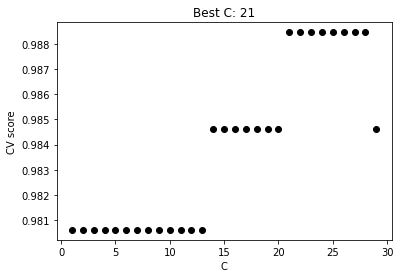

In [ ]:
best_c = best_complexity(LogisticRegression(), X_train, y_train, show_cv = True)

#### ii.) Random Forest Classifier

Best CV: 0.9846153846153847


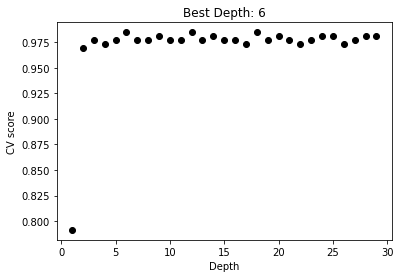

In [ ]:
best_depth = best_complexity(RandomForestClassifier(), X_train, y_train, show_cv = True)

#### iii.) Supper Vector Machine

Best CV: 0.9807692307692308


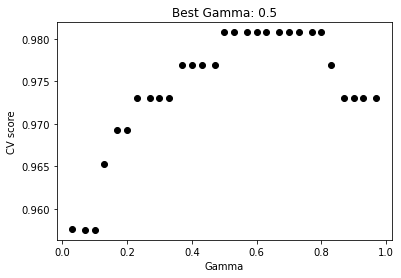

In [ ]:
best_gamma = best_complexity(svm.SVC(), X_train, y_train, show_cv = True)

### Displaying Confusion Matrices and Decision Regions

#### i.) Multinomial Logistic Regression

Accuracy: 96.923%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


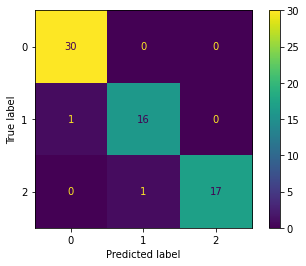

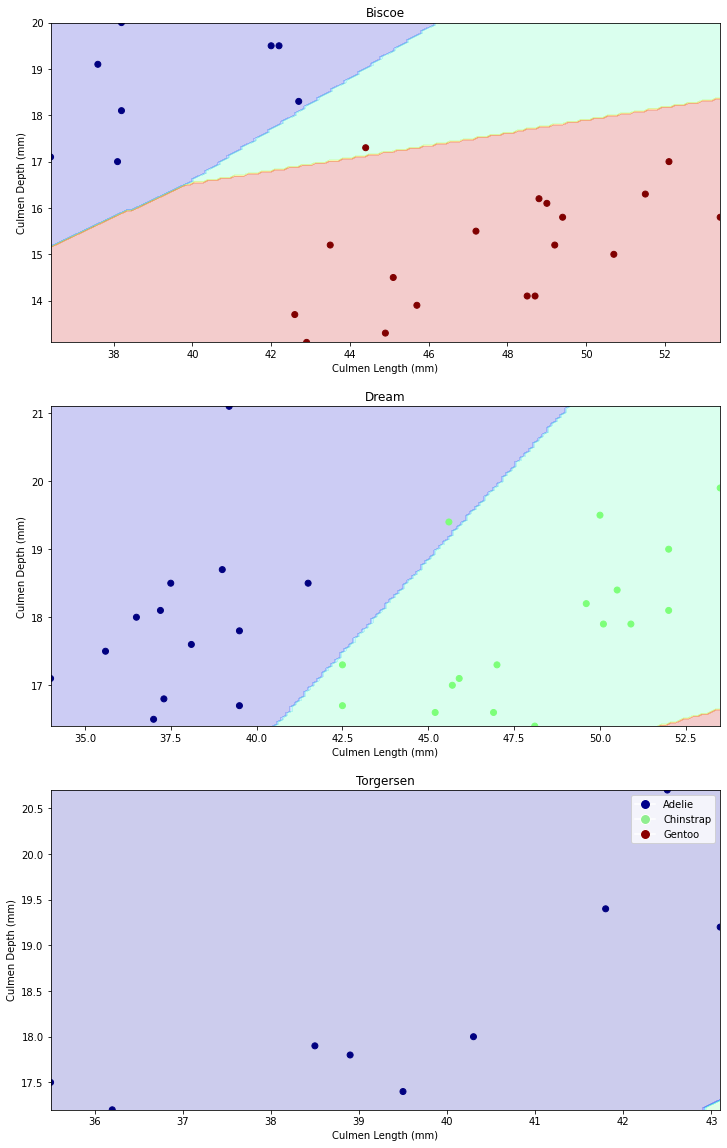

In [ ]:
LR = LogisticRegression(multi_class='multinomial', solver = 'lbfgs', C = best_depth, max_iter = 1000)


LR.fit(X_train,y_train)
test_classifier(LR)
plot_confusion_matrix(LR, X_test, y_test)

#Create plot here
fig, ax = plt.subplots(3, figsize = (12, 20))
for i in range (3):
    plot_regions(LR, X_test, y_test, i)

In [ ]:
find_mistakes(LR)

     Culmen Length (mm)  Culmen Depth (mm)  Island
211                45.6               19.4       1
257                44.4               17.3       0


*How it works*

Multinomial logistic regression uses maximum likelihood estimation
to evaluate the probability of categorical membership.

*Discussion of Mistakes*

Logistic Regression has linear decision boundaries. From the decision regions and confusion matrix, the model does have some mistakes. Since Gentoo penguins usually have lower culmen depths and lower culmen lengths, the model misclassified a Gentoo penguin on the Biscoe island with an unusually high culmen depth for a low culmen length as a Chinstrap penguin. In the data, Chinstrap penguins typically have lower culmen lengths combined with high culmen depths. 

However, this mistake is surprising because there are no Chinstrap penguins on the Biscoe island in the training data, so we expected the model to rule out Chinstrap as a possibility for all Biscoe island penguins. 

Similarities in culmen length and culmen depth among some Adelie and Chinstrap penguins led to the misclassification of one Chinstrap penguin as an Adelie penguin. 


#### ii.) Random Forest Classifier

Accuracy: 100.000%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


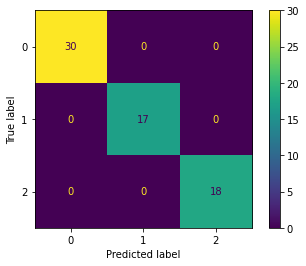

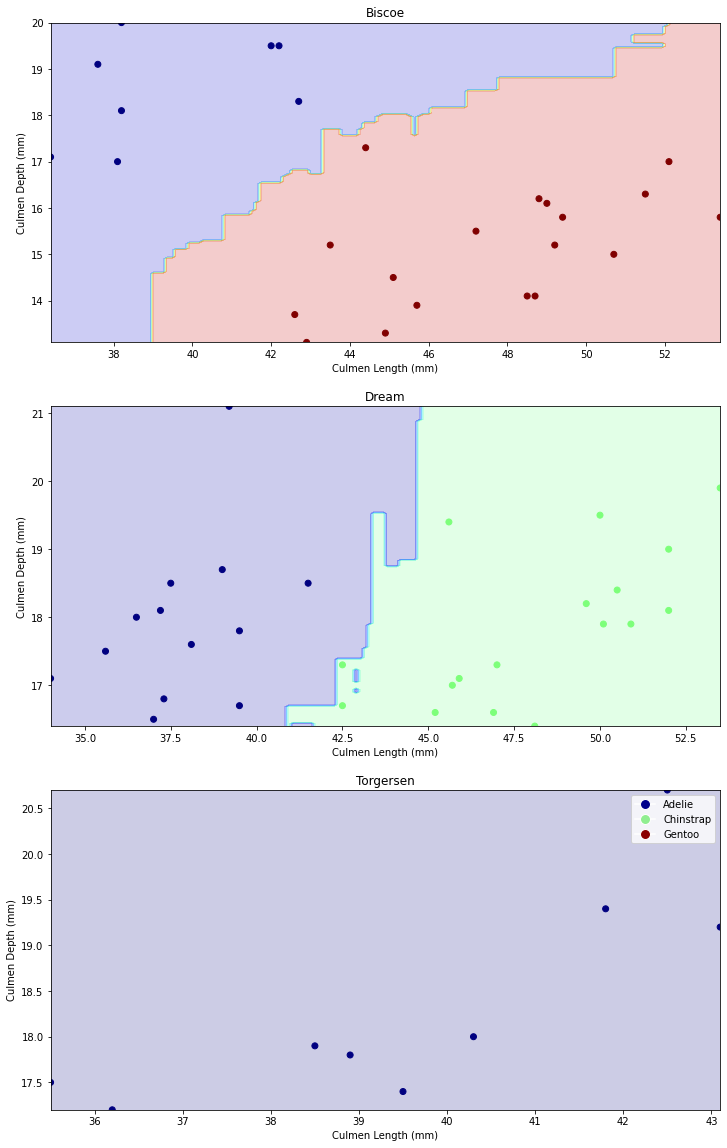

In [ ]:

RF = RandomForestClassifier(max_depth = best_depth)

#Decision Region
RF.fit(X_train,y_train)
test_classifier(RF)
plot_confusion_matrix(RF, X_test, y_test)
#Create plot here
fig, ax = plt.subplots(3, figsize = (12, 20))
for i in range (3):
    plot_regions(RF, X_test, y_test, i)




In [ ]:
find_mistakes(RF)

Empty DataFrame
Columns: [Culmen Length (mm), Culmen Depth (mm), Island]
Index: []


*How it works*

The "forest" it builds, is an ensemble of decision trees, usually trained with the bagging method. The general idea of the bagging method is that a combination of learning models increases the overall result.


*Discussion of Mistakes*

Random Tree creates rectangular decision boundaries. There are not any mistakes made by this model. This is evident on the confusion matrix since it is a diagonal matrix. Also, on the decision regions, all of the peguin species are mapped to their correct region. There seems to be some confusion on the Dream island about whether two of the Chinstrap peguins are on the edge of Chinstrap and Adelie. Utimately, the model is correct because there do not exist any mistakes in the mistakes dataframe. 

#### iii.) Support Vector Machine

Accuracy: 98.462%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


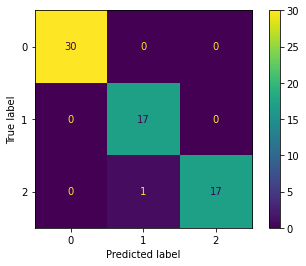

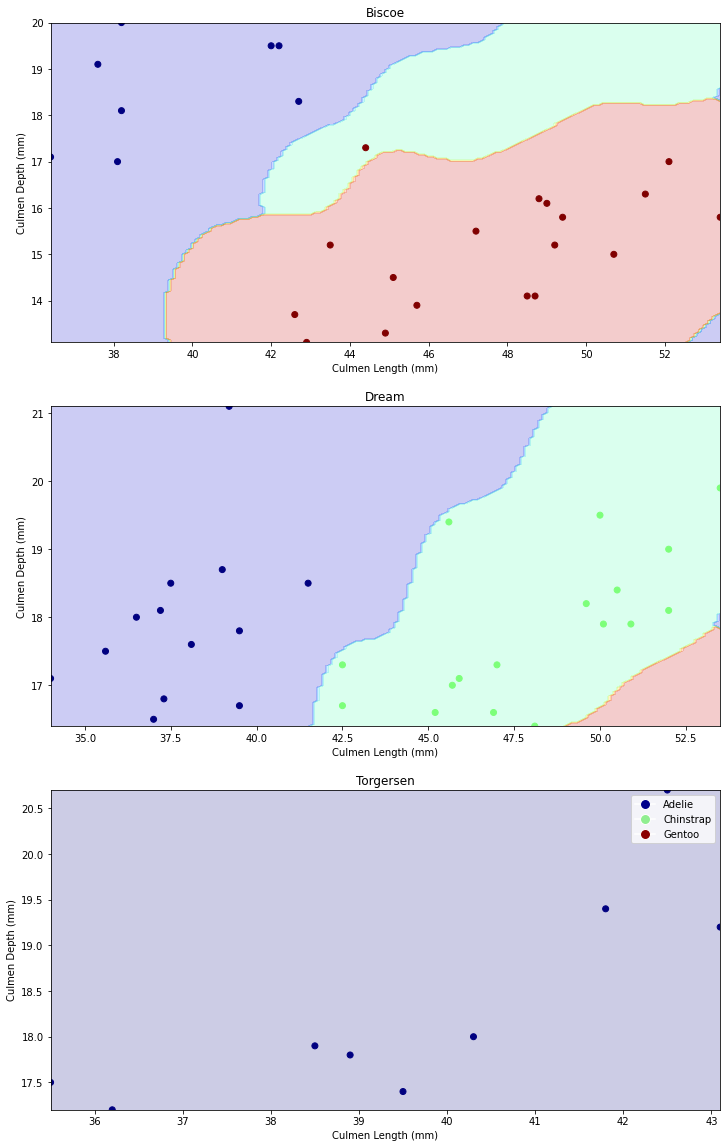

In [ ]:
#Support Vector Machines
SVM = svm.SVC(gamma = best_gamma)

#Evaluation on unseen data
SVM.fit(X_train, y_train)
test_classifier(SVM)

#Confusion Matrix
plot_confusion_matrix(SVM, X_test, y_test)
#Create plot here
fig, ax = plt.subplots(3, figsize = (12, 20))
for i in range (3):
    plot_regions(SVM, X_test, y_test, i)

In [ ]:
find_mistakes(SVM)

     Culmen Length (mm)  Culmen Depth (mm)  Island
257                44.4               17.3       0


*How it works*

The algorithm creates a line or a hyperplane which separates the data into classes.

*Discussion of Mistakes*

Support Vectorized machines had circular regions. For similar reasons of misclassification as in the multinomial logistic regression model, a Gentoo penguin was misclassified as a Chinstrap penguin. 

## Conclusion

Our Random Forest model was the best with 100% accuracy. Multinomial logistic regression performed the worst with 97% accuracy. It seems that Culmen length and culmen depth were the best features as seen from our cross validation scores. However, some Chinstrap peguins on the Dream island have culmen length and depth similar to Adelie peguins, which was a source of confusion for the Logistic Regression model. Since Gentoos usually have The Linear Regression and Vector machines models could have pheraps worked better with different features. 